<div style="padding: 30px 60px; border: 5px skyblue solid; border-radius: 30px; max-width: 600px; font-size: 2rem; line-height: 3rem; color: black; font-family: sans-serif;">

  <div style="font-size: 1.5rem; font-weight: 200;">[CM3070] Final Project - BSc CS University of London</div>
  <div style="font-size: 1.5rem; font-weight: 500;">Deep Learning on Satellite Imagery</div>
  <div style="font-size: 2rem; color: dodgerblue; font-weight: bold;">by Arjun Bajaj</div>
</div>

# State-of-the-Art Models

This notebook implements State-of-the-Art models with ImageNet weights. As the assignment states no pre-trained weights can be used, this notebook is built only for demonstration purposes; to show how well or bad does the EuroSAT dataset perform when replicating the paper's findings. The EuroSAT paper states they achieve `98+%` accuracy with `ResNet50`. However, as evident below, it is hard to replicate their findings, as they haven't given other crucial details, such as how the data was processed and what other layers they had added to their model. Two architectures, `ResNet50` and `VGG16` are demonstrated below. These models aren't used further for any purpose as pre-trained weights aren't allowed for this project.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from core import load_eurosat, compile_and_train_model

In [3]:
with tf.device('/cpu:0'):
  # Data Augmentation Workflow
  data_augmentation = keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ])

  # Load the dataset without caching
  (train, val, test) = load_eurosat(no_cache=True, batch_size=128)

  # Lambda to apply data augmentation
  augment = lambda x, y: (data_augmentation(x), y)

  # Lambda to apply ResNet50 input preprocessing (required for Keras Applications)
  resnet_preprocess = lambda x, y: (keras.applications.resnet_v2.preprocess_input(x), y)

  # Lambda to apply VGG16 input preprocessing (required for Keras Applications)
  vgg16_preprocess = lambda x, y: (keras.applications.vgg16.preprocess_input(x), y)

  # Lambda to apply data augmentation, input preprocessing, and prefetching and caching a dataset
  process_ds = lambda ds, proc: ds.map(augment).map(proc).prefetch(tf.data.AUTOTUNE).cache()

  # Create the dataset for ResNet50
  resnet_dataset = (
    process_ds(train, resnet_preprocess),
    process_ds(val, resnet_preprocess),
    process_ds(test, resnet_preprocess)
  )

  # Create the dataset for VGG16
  vgg_dataset = (
    process_ds(train, vgg16_preprocess),
    process_ds(val, vgg16_preprocess),
    process_ds(test, vgg16_preprocess)
  )

Found 21600 files belonging to 10 classes.
Found 2700 files belonging to 10 classes.
Found 2700 files belonging to 10 classes.


# ResNet50

The `ResNet50V2` Keras Application is used below. The final model contains `23.5` million trainable parameters, and takes 24 minutes to train for `10` epochs. It reaches a validation accuracy of `89.78%`.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 23,539,850
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
169/169 [==============================] - 121s 640ms/step - loss: 0.7446 - accuracy: 0.7746

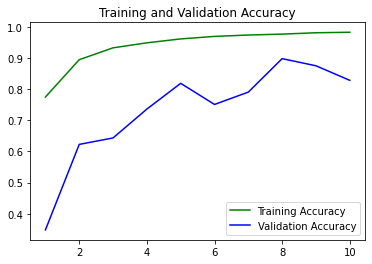

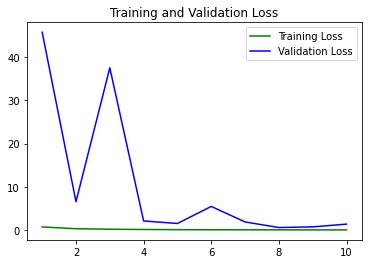

22/22 [==============================] - 7s 256ms/step - loss: 0.6057 - accuracy: 0.8978

Trained for 10 epochs in 24m41s.
Highest Validation Accuracy: 89.78%


In [5]:
resnet = keras.applications.ResNet50V2(
  weights='imagenet', input_shape=(64, 64, 3), include_top=False
)

resnet_model = keras.Sequential([
  resnet,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.25),
  layers.Dense(10, activation='softmax')
])

resnet_model.summary()

compile_and_train_model(resnet_model, "resnet50.keras", resnet_dataset, epochs=10)

# VGG16

The `VGG16` Keras Application is used below. The final model contains `14.7` million trainable parameters, and takes 44 minutes to train for `10` epochs. It reaches a validation accuracy of `82.52%`.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
169/169 [==============================] - 269s 2s/step - loss: 276.6706 - accuracy: 0.1454 - val

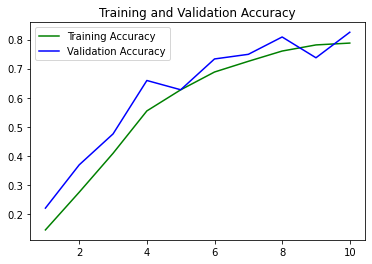

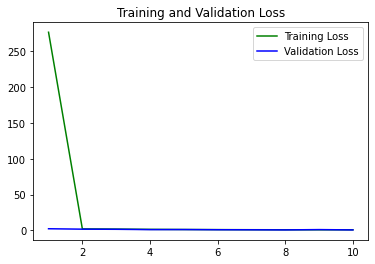

22/22 [==============================] - 9s 380ms/step - loss: 0.5514 - accuracy: 0.8252

Trained for 10 epochs in 44m17s.
Highest Validation Accuracy: 82.52%


In [6]:
vgg16 = keras.applications.VGG16(
  weights='imagenet', input_shape=(64, 64, 3), include_top=False
)

vgg16_model = keras.Sequential([
  vgg16,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.25),
  layers.Dense(10, activation='softmax')
])

vgg16_model.summary()

compile_and_train_model(vgg16_model, "vgg16.keras", vgg_dataset, epochs=10)

# Results

The `ResNet50V2` model outperforms the `VGG16` model in terms of both the accuracy and time to train. Newer architectures are known to be better in multiple ways, and this demonstrates that. The `Xception` architecture, one of the latest state-of-the-art architectures for image classification was also explored. However, `Xception` requires a minimum image size of `71x71px`, whereas the EuroSAT dataset is `64x64px`. Scaling up the images lead to considerable accuracy loss. Hence, the `Xception` architecture wasn't explored further. Overall, as the previous and subsequent notebooks show, it is possible to build much smaller models without any pre-trained weights which achieve higher accuracy in a shorter amount of training time, compared to the models implemented in this notebook. It is however completely possible, as the EuroSAT paper suggests, that these architectures may achieve much higher accuracies if trained for many more epochs.

----